In [127]:
import pandas as pd
import tarfile

import numpy as np
import pandas as pd
import rdkit.Chem as Chem
from torch.utils.data import Dataset
from rdkit.Chem import Descriptors

In [128]:
class QM9Dataset(Dataset):
    def __init__(self, h5_file=None, xyz_file=None, train=True, targets='gap', split_seed=142857, ratio=0.9):
        if h5_file is not None:
            self.df = pd.HDFStore(h5_file, 'r')['df']
        elif xyz_file is not None:
            self.load_tar()
        rng = np.random.default_rng(split_seed)
        idcs = np.arange(len(self.df))  # TODO: error if there is no h5_file provided. Should h5 be required
        rng.shuffle(idcs)
        self.targets = targets
        if train:
            self.idcs = idcs[:int(np.floor(ratio * len(self.df)))]
        else:
            self.idcs = idcs[int(np.floor(ratio * len(self.df))):]
        self.targets = ['gap', 'logP']
        self.length = len(self.df["SMILES"])
        self.calculate_logP()
        # self.calculate_QED()
        # self.calculate_molwt()

    def gather_rewards(self, idx):
        rewards = []
        for target in self.targets:
            rewards.append(self.df[target][idx])
        return np.asarray(rewards)

    def get_stats(self, target, percentile=0.95):
        # Return a list of stats
        y = self.df[target]
        return y.min(), y.max(), np.sort(y)[int(y.shape[0] * percentile)]

    def calculate_logP(self):
        logP = []
        for idx in range(self.length):
            molecule = self.df['SMILES'][idx]
            molecule = Chem.MolFromSmiles(molecule)
            logP.append(Descriptors.MolLogP(molecule))
        self.df["logP"] = logP

    def calculate_QED(self):
        QED = []
        for idx in range(self.length):
            molecule = self.df['SMILES'][idx]
            molecule = Chem.MolFromSmiles(molecule)
            QED.append(Descriptors.qed(molecule))
        self.df["QED"] = QED

    def calculate_molwt(self):
        mol_weight = []
        for idx in range(self.length):
            molecule = self.df['SMILES'][idx]
            molecule = Chem.MolFromSmiles(molecule)
            mol_weight.append(Descriptors.MolWt(molecule))
        self.df["molecular_weight"] = mol_weight

    def load_tar(self, xyz_file):
        f = tarfile.TarFile(xyz_file, 'r')
        labels = ['rA', 'rB', 'rC', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv']
        all_mols = []
        for pt in f:
            pt = f.extractfile(pt)
            data = pt.read().decode().splitlines()
            all_mols.append(data[-2].split()[:1] + list(map(float, data[1].split()[2:])))
        self.df = pd.DataFrame(all_mols, columns=['SMILES'] + labels)

    def __len__(self):
        return len(self.idcs)

    def __getitem__(self, idx):
        rewards = self.gather_rewards(idx)
        return (Chem.MolFromSmiles(self.df['SMILES'][self.idcs[idx]]), rewards)


In [129]:
h5_file = '/data/chem/qm9/qm9.h5'
dataset = QM9Dataset(h5_file, train=True)

In [130]:
mols, flat_rewards = map(list, zip(*[dataset[i] for i in range(32)]))

In [131]:
a = torch.FloatTensor(np.vstack(flat_rewards))
m = torch.distributions.dirichlet.Dirichlet(torch.FloatTensor([1.5] * 2))
b = m.sample([32])

In [118]:

c = torch.bmm(a, b.unsqueeze(1).permute(0, 2, 1))
print(c.squeeze(1))
# c_1 = torch.dot(a[0], b[0])


RuntimeError: Expected 3-dimensional tensor, but got 2-dimensional tensor for argument #1 'batch1' (while checking arguments for bmm)

In [79]:
df = pd.HDFStore(h5_file, 'r')['df']
df.head()

,SMILES,rA,rB,rC,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv
0,C,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469
1,N,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316
2,O,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002
3,C#C,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574
4,C#N,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278


In [80]:
import matplotlib.pyplot as plt
molecules = df["SMILES"]
len(molecules)
logp = []
for m in molecules:
    mol = Chem.MolFromSmiles(m)
    logp.append(Descriptors.MolLogP(mol))


In [81]:
print(len(molecules))

133885


(array([   92.,   661.,  2190.,  5962., 12554., 27601., 43471., 30576.,
         9428.,  1350.]),
 array([0.12269723, 0.17730723, 0.23191723, 0.28652722, 0.34113722,
        0.39574722, 0.45035722, 0.50496722, 0.55957721, 0.61418721,
        0.66879721]),
 <BarContainer object of 10 artists>)

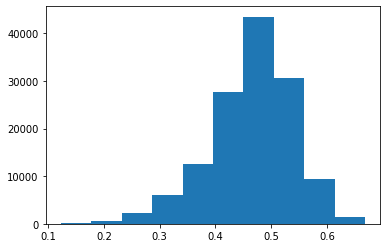

In [64]:
plt.hist(logp
        )

In [65]:
import torch

In [66]:
a = torch.FloatTensor([1, 2, 3]).dot(torch.tensor([1, 2, 3]))

In [67]:
a

tensor(14)

In [134]:
m = torch.distributions.dirichlet.Dirichlet(torch.tensor([1.5] * 1))
preferences = m.sample([32])

In [136]:
print(preferences.shape)

torch.Size([32, 1])


In [73]:
a

tensor(2.2494)

In [120]:
import numpy as np

In [122]:
a = [[1.0, 2.0], [3.12, 1.0009]]
a = np.asarray(a)

In [125]:
a[np.isnan(a)] = 1

In [126]:
a

array([[1.    , 2.    ],
       [3.12  , 1.0009]])

In [138]:
a = torch.ones((128, 1))
beta = torch.ones((128, 1))
c = a ** beta
c.shape

torch.Size([128, 1])

In [139]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

In [141]:
from packaging import version

major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)

TensorBoard version:  2.8.0


In [150]:
experiment_id = "[22101]"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()

_MultiThreadedRendezvous: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.INTERNAL
	details = "Internal error. Please report this and specify reference code 1a466559-d728-4682-8c96-567b213834eb."
	debug_error_string = "{"created":"@1654462610.824165834","description":"Error received from peer ipv4:34.95.66.171:443","file":"src/core/lib/surface/call.cc","file_line":903,"grpc_message":"Internal error. Please report this and specify reference code 1a466559-d728-4682-8c96-567b213834eb.","grpc_status":13}"
>